<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [4]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [5]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [6]:
# Feature Data

fa_cup_raw_features = """
    select * from preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,1,1,12,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,41837,1,1,1,1,1,12,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,1,1,12,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,1,1,12,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,1,0,2,3,7,4,6,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2150,6,0,63,62,59,57,52,62,62,...,41.30,0.004,0.0,0.04,13.65,1022.25,11.80,94.85,"Overcast Rain, Partially cloudy",0
301,<NA>,6,0,64,58,64,53,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,9527,4,1,64,58,64,53,63,64,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,6,0,64,58,64,53,63,64,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [7]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_slr = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    #preprocessor = ColumnTransformer(
     #   transformers=[
      #      ('num', numeric_transformer, numeric_features),
       #     ('cat', categorical_transformer, categorical_features),
        #    ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        #], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        #X_train, home_advantage_column = add_home_advantage(X_train)
        #X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        #numeric_features_with_ha = [home_advantage_column] + numeric_features
        #print(numeric_features_with_ha)

        # Update preprocessor with current features including home advantage
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(X_train_preprocessed_df)
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slr = all_results_df_slr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_slr)


In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression with home advantage"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_slrh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

        # Update preprocessor with current features including home advantage
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features_with_ha),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(X_train_preprocessed_df)
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slrh = all_results_df_slrh.merge(results_df, on=['metric_id', 'metric'], how='outer')

    display(all_results_df_slrh)


Weighted LogisticRegression round_3_position
Fold 1 Accuracy: 0.541
Fold 2 Accuracy: 0.574
Fold 3 Accuracy: 0.541
Fold 4 Accuracy: 0.574
Fold 5 Accuracy: 0.475
Average Accuracy: 0.541
Weighted LogisticRegression massey
Fold 1 Accuracy: 0.607
Fold 2 Accuracy: 0.607
Fold 3 Accuracy: 0.574
Fold 4 Accuracy: 0.574
Fold 5 Accuracy: 0.557
Average Accuracy: 0.584
Weighted LogisticRegression colley
Fold 1 Accuracy: 0.574
Fold 2 Accuracy: 0.623
Fold 3 Accuracy: 0.574
Fold 4 Accuracy: 0.590
Fold 5 Accuracy: 0.525
Average Accuracy: 0.577
Weighted LogisticRegression keener
Fold 1 Accuracy: 0.607
Fold 2 Accuracy: 0.574
Fold 3 Accuracy: 0.557
Fold 4 Accuracy: 0.590
Fold 5 Accuracy: 0.557
Average Accuracy: 0.577
Weighted LogisticRegression trueskill
Fold 1 Accuracy: 0.639
Fold 2 Accuracy: 0.639
Fold 3 Accuracy: 0.574
Fold 4 Accuracy: 0.574
Fold 5 Accuracy: 0.623
Average Accuracy: 0.610
Weighted LogisticRegression borda_count
Fold 1 Accuracy: 0.623
Fold 2 Accuracy: 0.607
Fold 3 Accuracy: 0.574
Fold 4 A

,metric_id,metric,Weighted LogisticRegression round_3_position,Weighted LogisticRegression massey,Weighted LogisticRegression colley,Weighted LogisticRegression keener,Weighted LogisticRegression trueskill,Weighted LogisticRegression borda_count,Weighted LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.541,0.584,0.577,0.577,0.610,0.593,0.590
1,2,Overall Accuracy,0.541,0.584,0.577,0.577,0.610,0.593,0.590
2,3,Confusion Matrix - True Negative (Class 0),126.000,137.000,138.000,136.000,143.000,141.000,139.000
3,4,Confusion Matrix - False Positive (Class 1),97.000,86.000,85.000,87.000,80.000,82.000,84.000
4,5,Confusion Matrix - False Negative (Class 0),43.000,41.000,44.000,42.000,39.000,42.000,41.000
5,6,Confusion Matrix - True Positive (Class 1),39.000,41.000,38.000,40.000,43.000,40.000,41.000
6,7,Precision (Class 0),0.746,0.770,0.758,0.764,0.786,0.770,0.772
7,8,Recall (Class 0),0.565,0.614,0.619,0.610,0.641,0.632,0.623
8,9,F1-score (Class 0),0.643,0.683,0.681,0.678,0.706,0.695,0.690
9,10,Precision (Class 1),0.287,0.323,0.309,0.315,0.350,0.328,0.328


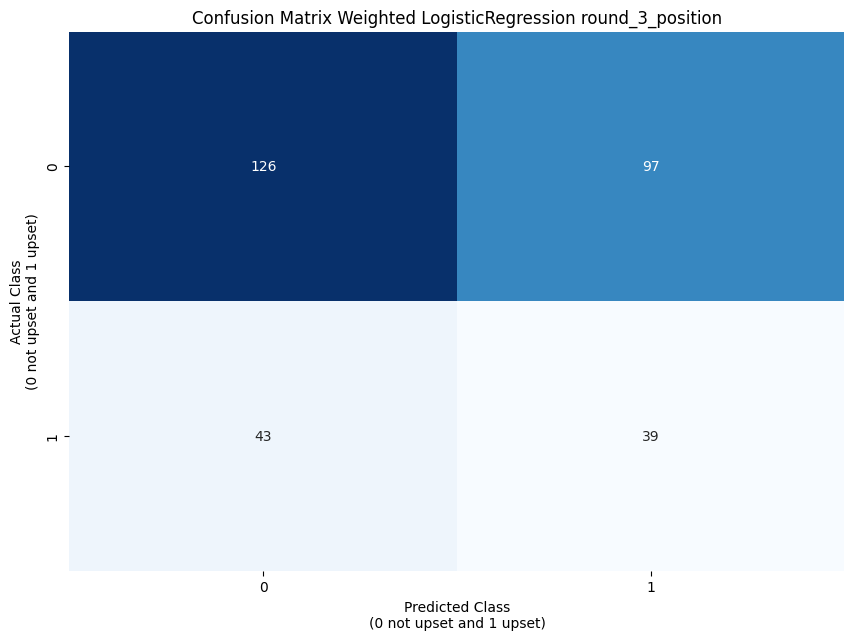

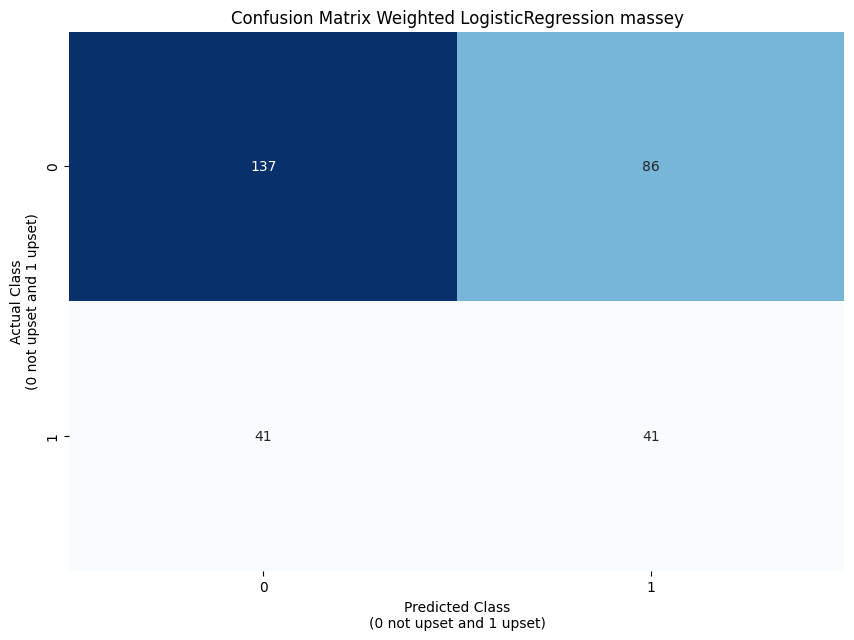

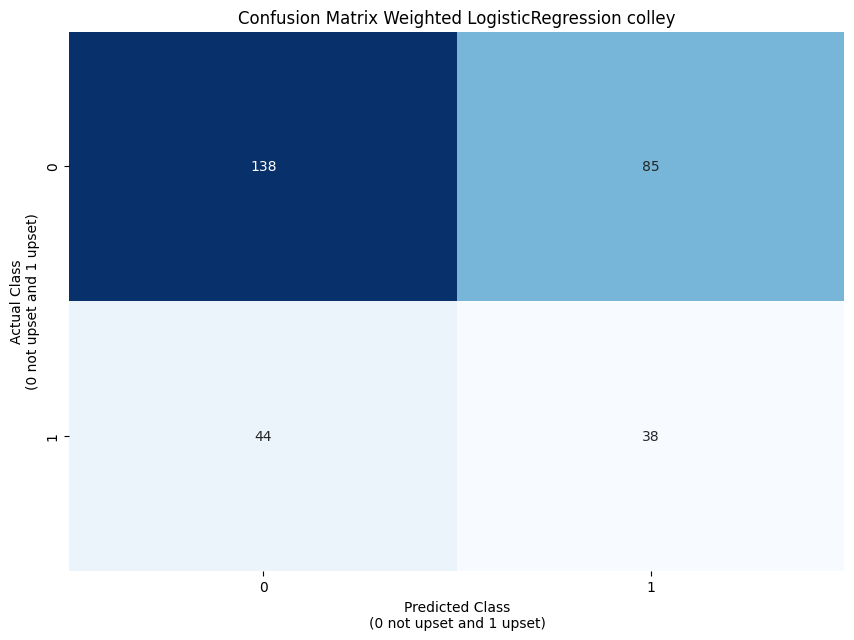

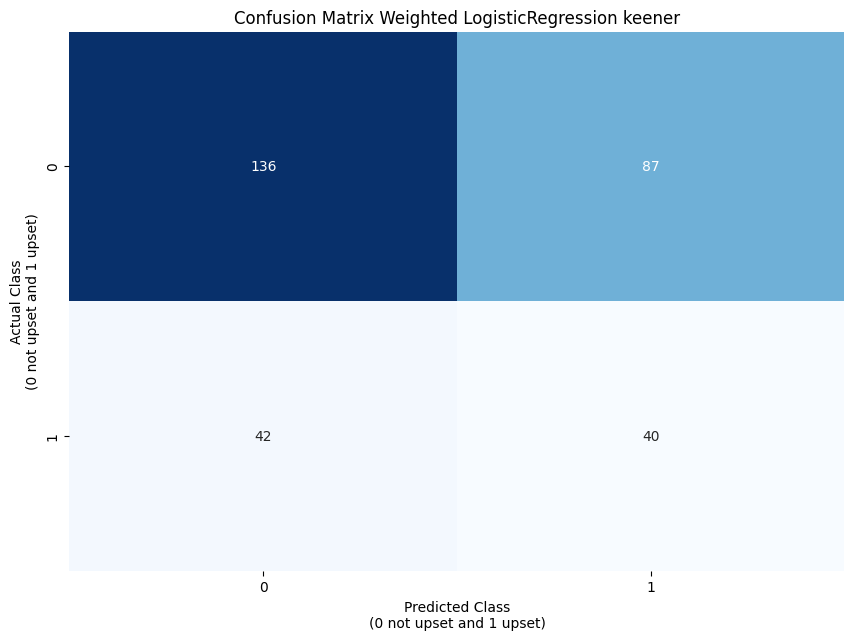

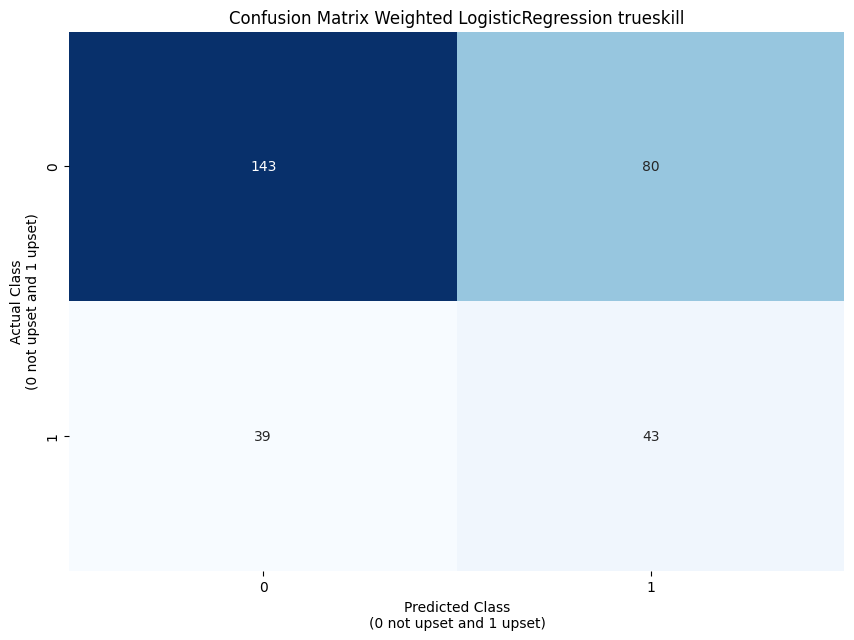

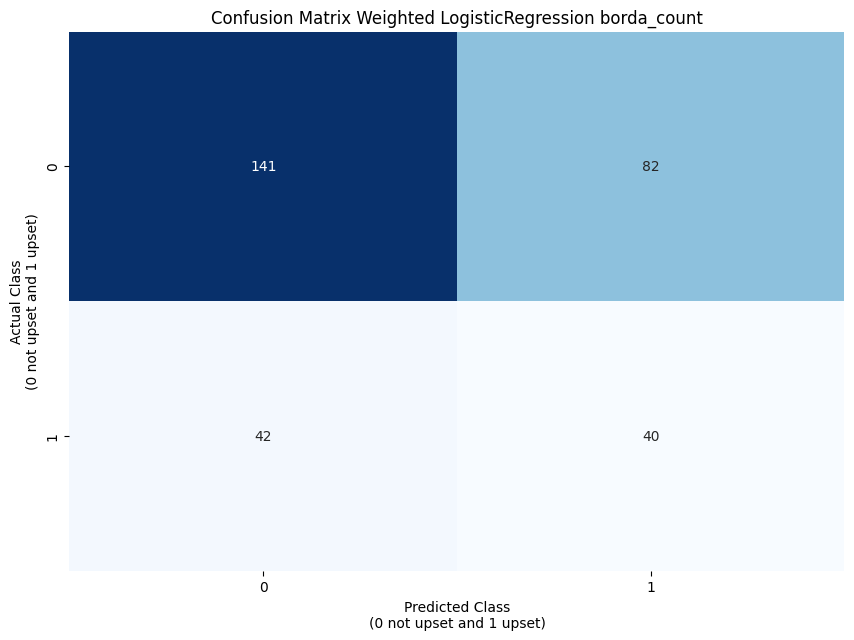

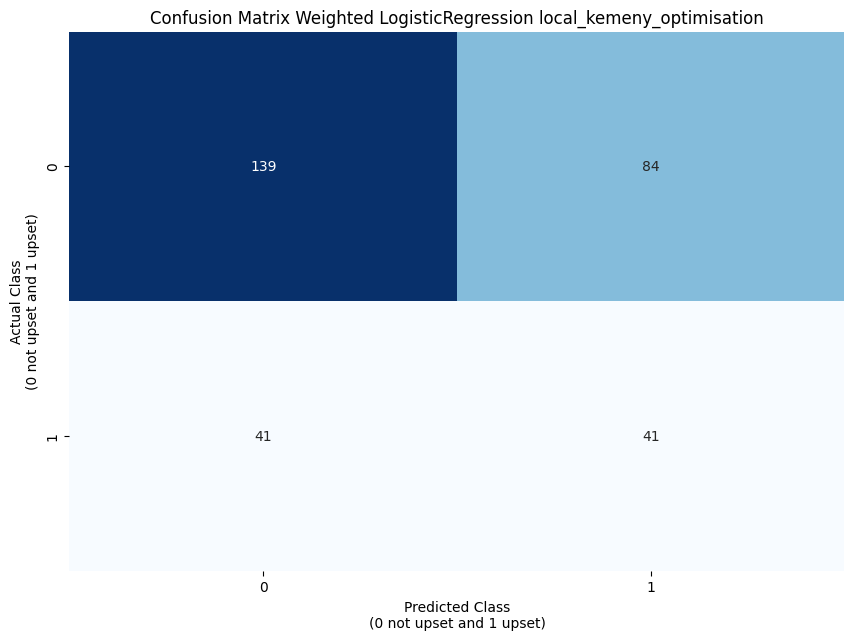

In [14]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
random_state= 47

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Empty df for consolidating confusion report results
all_results_df_wlr = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        #X_train, home_advantage_column = add_home_advantage(X_train)
        #X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        #numeric_features_with_ha = [home_advantage_column] + numeric_features
        #print(numeric_features_with_ha)

        # Update preprocessor with current features including home advantage
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_wlr = all_results_df_wlr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_wlr)


In [ ]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression with home advantage"
random_state= 47


# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Empty df for consolidating confusion report results
all_results_df_wlrh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

        # Update preprocessor with current features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features_with_ha),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_wlrh = all_results_df_wlrh.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_wlrh)


MLP Classifier Neural Network round_3_position
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.954
MLP Classifier Neural Network massey
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.951
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.934
Fold 5 Accuracy: 0.836
Average Accuracy: 0.931
MLP Classifier Neural Network colley
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.918
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.948
MLP Classifier Neural Network keener
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Classifier Neural Network trueskill
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.951
Fold 5 Accuracy: 0.902
Average Accuracy: 0.951
MLP Classifier Neural Network borda_count
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.

,metric_id,metric,MLP Classifier Neural Network round_3_position,MLP Classifier Neural Network massey,MLP Classifier Neural Network colley,MLP Classifier Neural Network keener,MLP Classifier Neural Network trueskill,MLP Classifier Neural Network borda_count,MLP Classifier Neural Network local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.954,0.931,0.948,0.938,0.951,0.954,0.954
1,2,Overall Accuracy,0.954,0.931,0.948,0.938,0.951,0.954,0.954
2,3,Confusion Matrix - True Negative (Class 0),219.000,220.000,219.000,219.000,220.000,221.000,221.000
3,4,Confusion Matrix - False Positive (Class 1),4.000,3.000,4.000,4.000,3.000,2.000,2.000
4,5,Confusion Matrix - False Negative (Class 0),10.000,18.000,12.000,15.000,12.000,12.000,12.000
5,6,Confusion Matrix - True Positive (Class 1),72.000,64.000,70.000,67.000,70.000,70.000,70.000
6,7,Precision (Class 0),0.956,0.924,0.948,0.936,0.948,0.948,0.948
7,8,Recall (Class 0),0.982,0.987,0.982,0.982,0.987,0.991,0.991
8,9,F1-score (Class 0),0.969,0.954,0.965,0.958,0.967,0.969,0.969
9,10,Precision (Class 1),0.947,0.955,0.946,0.944,0.959,0.972,0.972


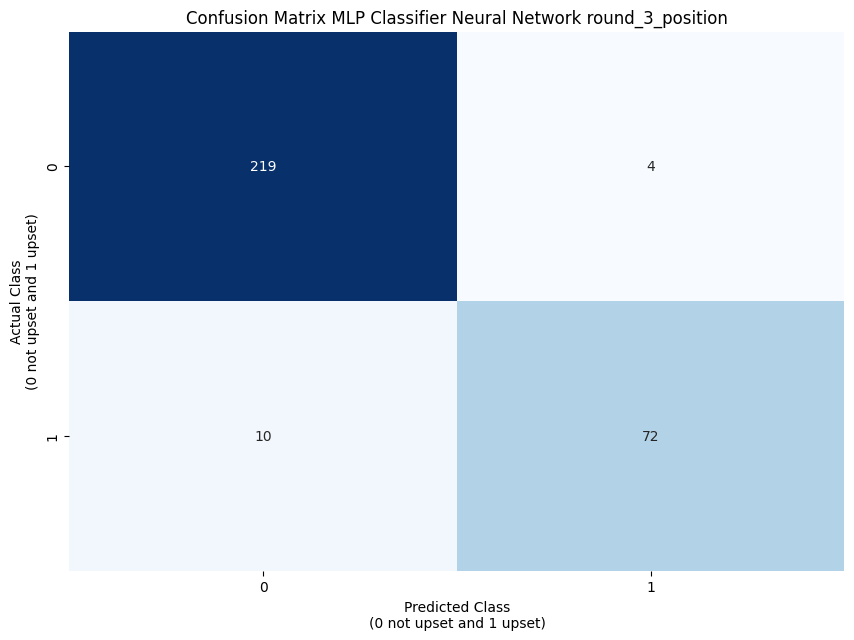

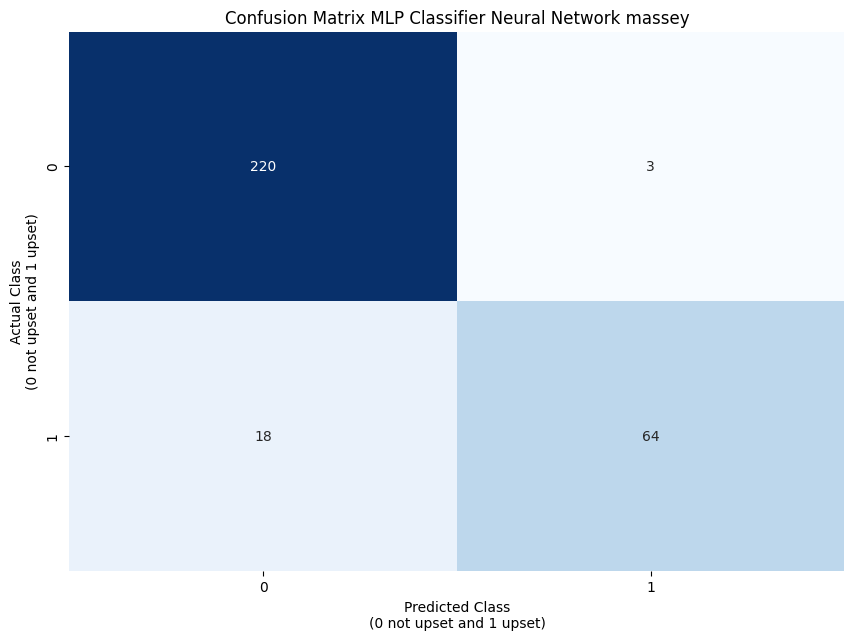

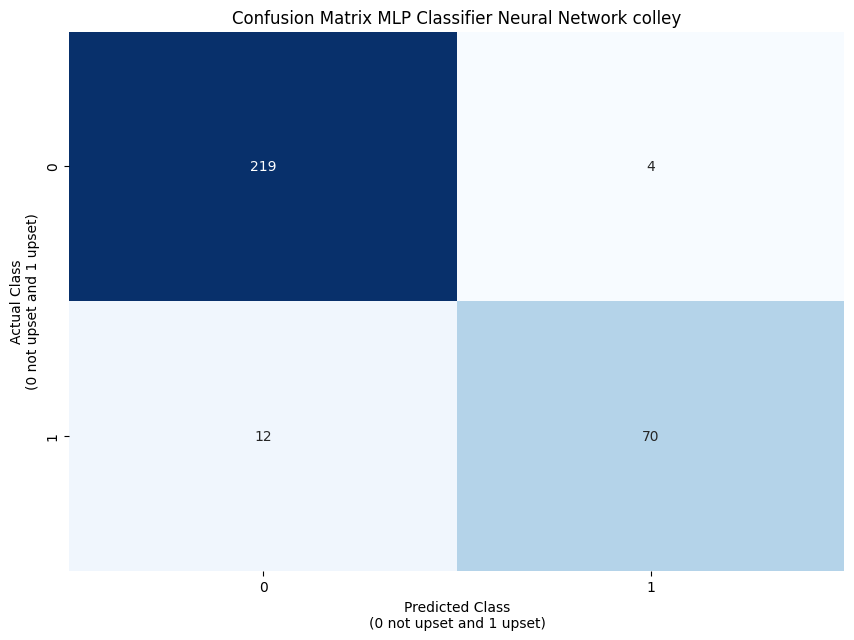

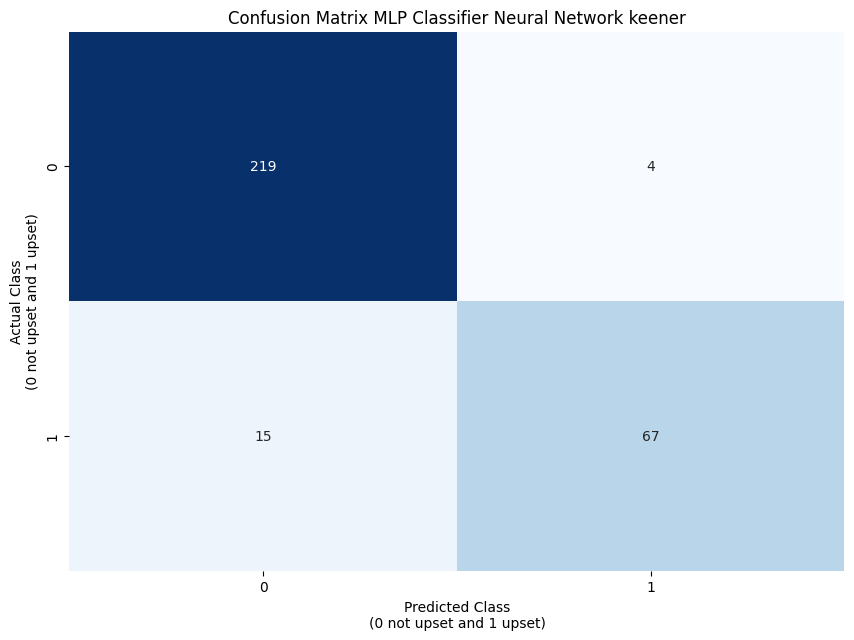

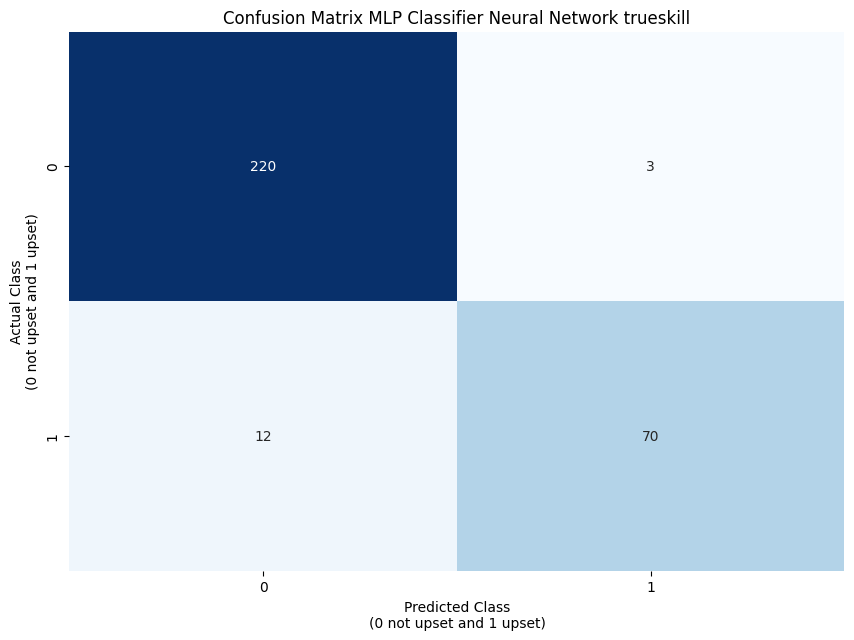

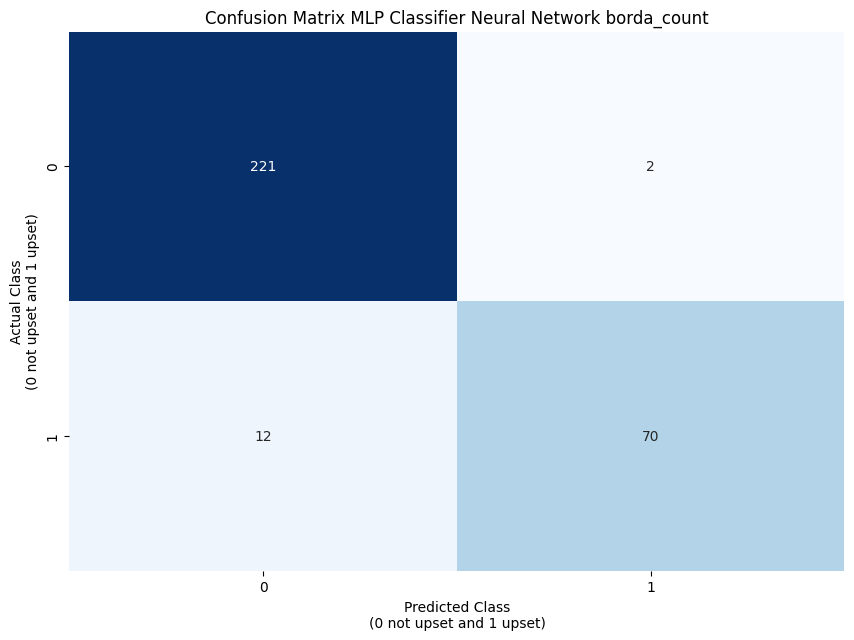

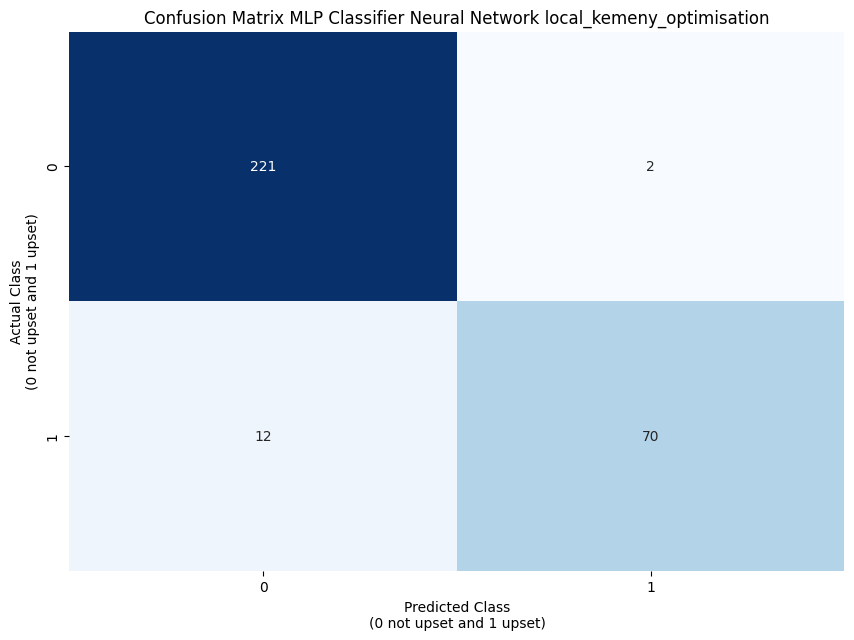

In [23]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nn = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Update preprocessor with current features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        print(f"\nFold {fold}")
        print("Preprocessed Train data:")
        display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        print("\nPreprocessed Test data:")
        display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nn = all_results_df_nn.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nn)


MLP Classifier Neural Network with home advantage round_3_position
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.984
Fold 5 Accuracy: 0.967
Average Accuracy: 0.974
MLP Classifier Neural Network with home advantage massey
Fold 1 Accuracy: 0.951
Fold 2 Accuracy: 0.951
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.902
Fold 5 Accuracy: 0.934
Average Accuracy: 0.934
MLP Classifier Neural Network with home advantage colley
Fold 1 Accuracy: 0.951
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.918
Fold 4 Accuracy: 0.885
Fold 5 Accuracy: 0.902
Average Accuracy: 0.925
MLP Classifier Neural Network with home advantage keener
Fold 1 Accuracy: 0.951
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.934
Fold 5 Accuracy: 0.885
Average Accuracy: 0.938
MLP Classifier Neural Network with home advantage trueskill
Fold 1 Accuracy: 0.967
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.902
Fold 4 Accuracy: 0.885
Fold 5 Accuracy: 0.918
Average Accuracy: 0.928
MLP Cla

,metric_id,metric,MLP Classifier Neural Network with home advantage round_3_position,MLP Classifier Neural Network with home advantage massey,MLP Classifier Neural Network with home advantage colley,MLP Classifier Neural Network with home advantage keener,MLP Classifier Neural Network with home advantage trueskill,MLP Classifier Neural Network with home advantage borda_count,MLP Classifier Neural Network with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.974,0.934,0.925,0.938,0.928,0.938,0.944
1,2,Overall Accuracy,0.974,0.934,0.925,0.938,0.928,0.938,0.944
2,3,Confusion Matrix - True Negative (Class 0),221.000,216.000,213.000,217.000,214.000,217.000,218.000
3,4,Confusion Matrix - False Positive (Class 1),2.000,7.000,10.000,6.000,9.000,6.000,5.000
4,5,Confusion Matrix - False Negative (Class 0),6.000,13.000,13.000,13.000,13.000,13.000,12.000
5,6,Confusion Matrix - True Positive (Class 1),76.000,69.000,69.000,69.000,69.000,69.000,70.000
6,7,Precision (Class 0),0.974,0.943,0.942,0.943,0.943,0.943,0.948
7,8,Recall (Class 0),0.991,0.969,0.955,0.973,0.960,0.973,0.978
8,9,F1-score (Class 0),0.982,0.956,0.949,0.958,0.951,0.958,0.962
9,10,Precision (Class 1),0.974,0.908,0.873,0.920,0.885,0.920,0.933


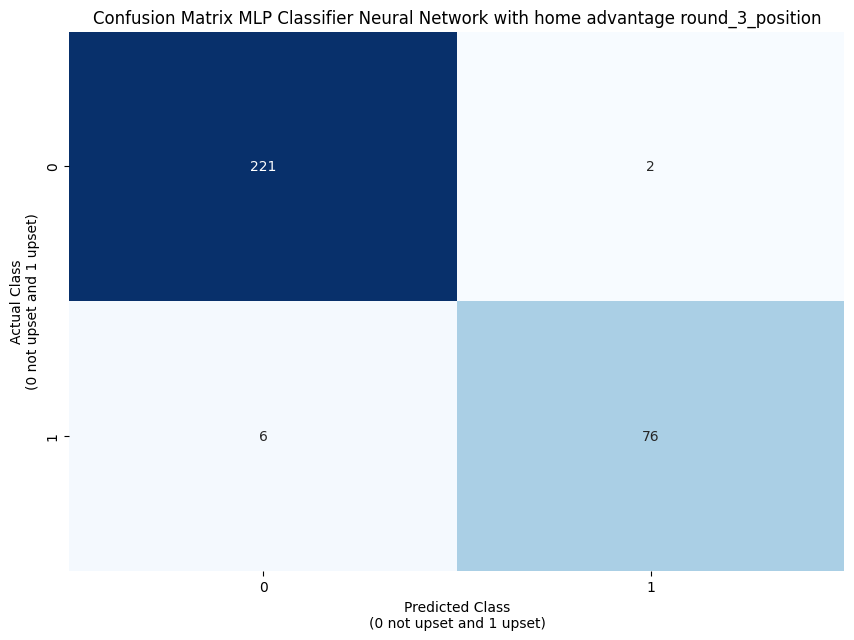

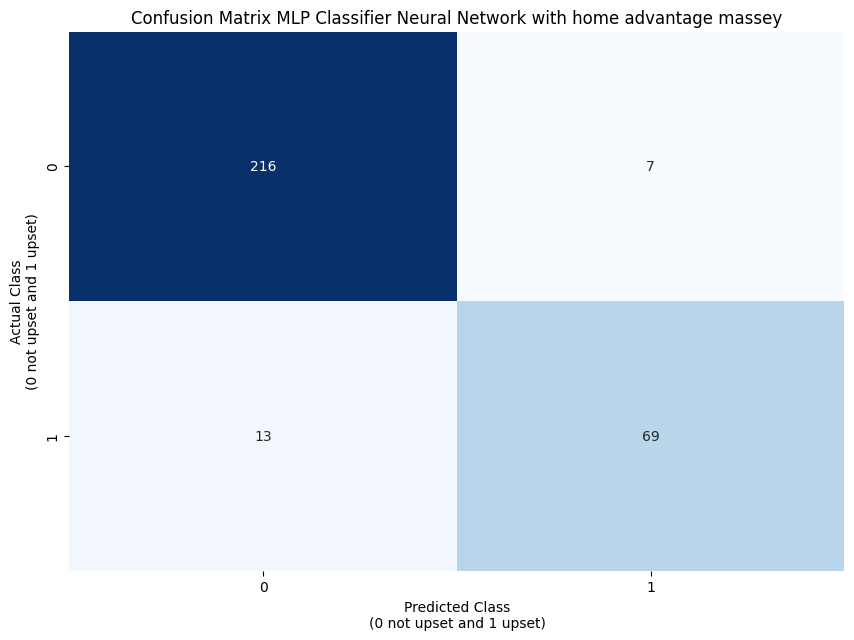

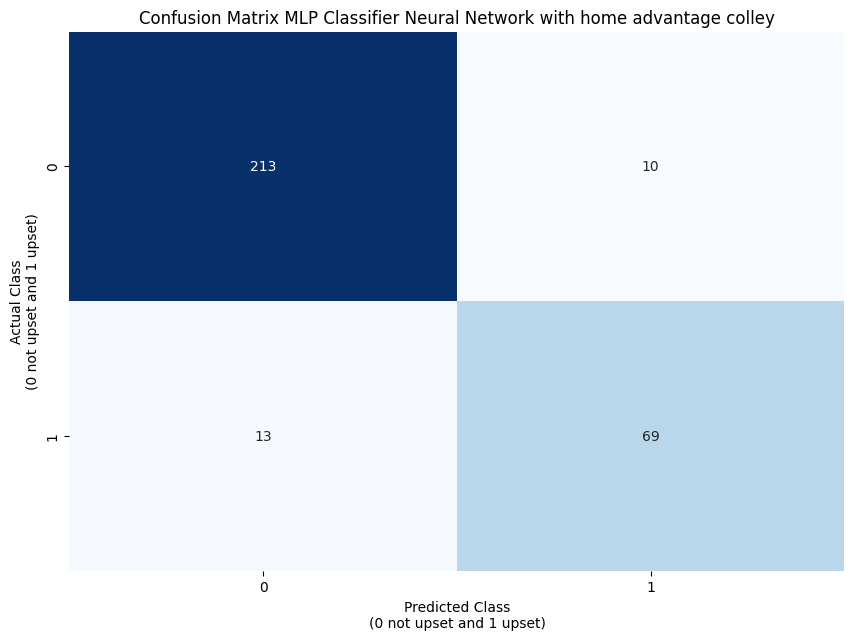

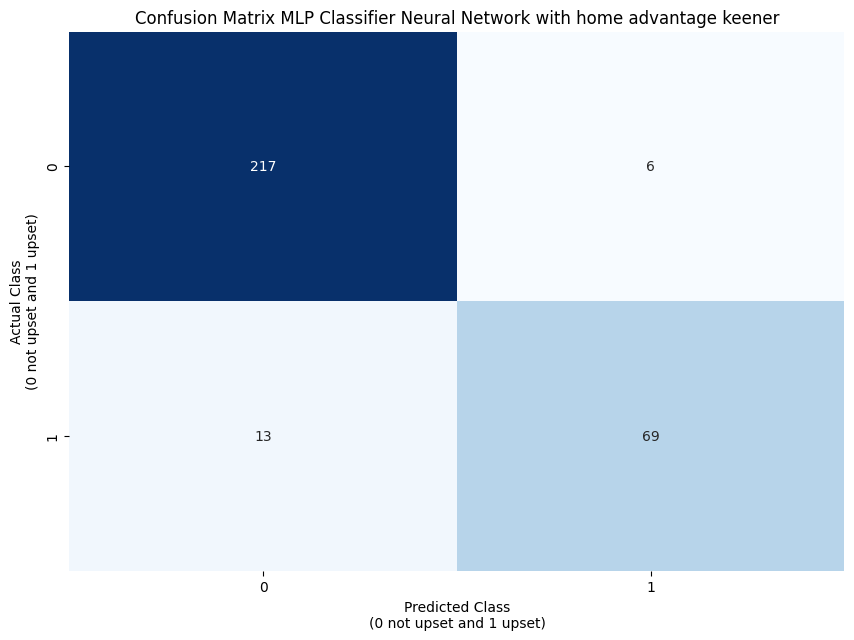

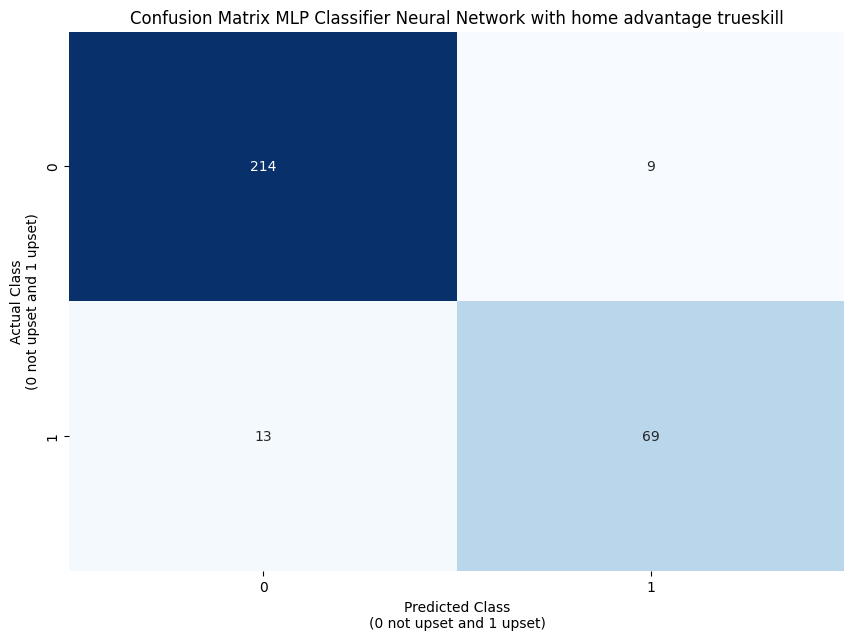

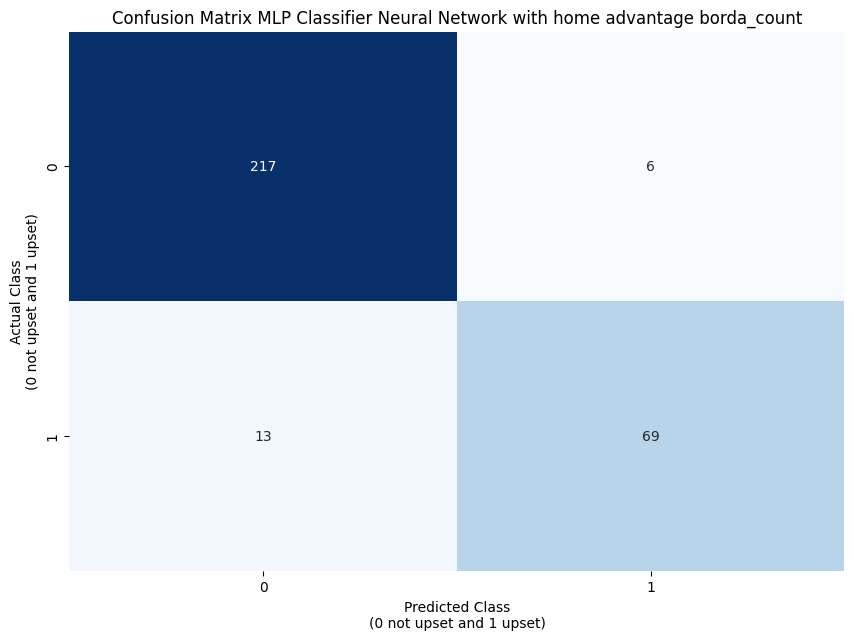

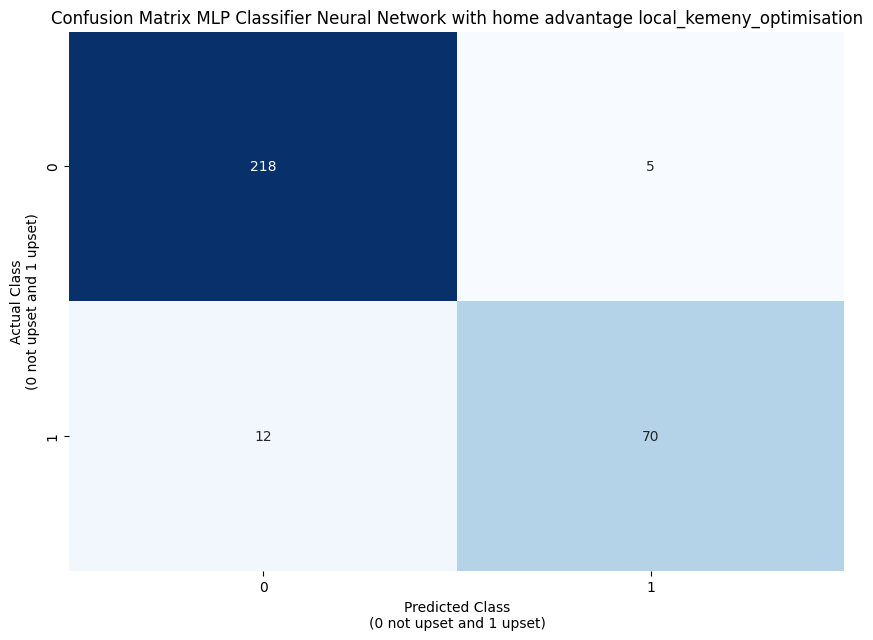

In [25]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network with home advantage"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nnh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

        # Update preprocessor with current features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features_with_ha),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)


        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nnh = all_results_df_nnh.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nnh)


In [29]:
all_results_df_lr = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df_slnn = all_results_df_nn.merge(all_results_df_lr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df_slnn, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

,metric_id,metric,MLP Classifier Neural Network with home advantage round_3_position,MLP Classifier Neural Network with home advantage massey,MLP Classifier Neural Network with home advantage colley,MLP Classifier Neural Network with home advantage keener,MLP Classifier Neural Network with home advantage trueskill,MLP Classifier Neural Network with home advantage borda_count,MLP Classifier Neural Network with home advantage local_kemeny_optimisation,MLP Classifier Neural Network round_3_position,...,Standard LogisticRegression with home advantage trueskill,Standard LogisticRegression with home advantage borda_count,Standard LogisticRegression with home advantage local_kemeny_optimisation,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.974,0.934,0.925,0.938,0.928,0.938,0.944,0.954,...,0.721,0.731,0.731,0.721,0.734,0.721,0.738,0.718,0.725,0.725
1,2,Overall Accuracy,0.974,0.934,0.925,0.938,0.928,0.938,0.944,0.954,...,0.721,0.731,0.731,0.721,0.734,0.721,0.738,0.718,0.725,0.725
2,3,Confusion Matrix - True Negative (Class 0),221.000,216.000,213.000,217.000,214.000,217.000,218.000,219.000,...,209.000,210.000,210.000,213.000,215.000,209.000,215.000,209.000,212.000,212.000
3,4,Confusion Matrix - False Positive (Class 1),2.000,7.000,10.000,6.000,9.000,6.000,5.000,4.000,...,14.000,13.000,13.000,10.000,8.000,14.000,8.000,14.000,11.000,11.000
4,5,Confusion Matrix - False Negative (Class 0),6.000,13.000,13.000,13.000,13.000,13.000,12.000,10.000,...,71.000,69.000,69.000,75.000,73.000,71.000,72.000,72.000,73.000,73.000
5,6,Confusion Matrix - True Positive (Class 1),76.000,69.000,69.000,69.000,69.000,69.000,70.000,72.000,...,11.000,13.000,13.000,7.000,9.000,11.000,10.000,10.000,9.000,9.000
6,7,Precision (Class 0),0.974,0.943,0.942,0.943,0.943,0.943,0.948,0.956,...,0.746,0.753,0.753,0.740,0.747,0.746,0.749,0.744,0.744,0.744
7,8,Recall (Class 0),0.991,0.969,0.955,0.973,0.960,0.973,0.978,0.982,...,0.937,0.942,0.942,0.955,0.964,0.937,0.964,0.937,0.951,0.951
8,9,F1-score (Class 0),0.982,0.956,0.949,0.958,0.951,0.958,0.962,0.969,...,0.831,0.837,0.837,0.834,0.841,0.831,0.843,0.829,0.835,0.835
9,10,Precision (Class 1),0.974,0.908,0.873,0.920,0.885,0.920,0.933,0.947,...,0.440,0.500,0.500,0.412,0.529,0.440,0.556,0.417,0.450,0.450


In [32]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'lr_ann_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6413.31it/s]
